In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import u_darrays as uda, constants as cnst
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import u_darrays
import ipdb
from utils import constants as cnst, u_met
import salem
from utils import u_statistics as us
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map


%matplotlib inline

/home/ck/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def calc_trend(data, month, hour=None, method=None, sig=False, wilks=False):

    y1 = 1985
    y2 = 2019

    if method is None:
        'Please provide trend calc method: polyfit or mk (mann kendall)'
    if hour is not None:

        if len(month)>1:

            data = data[((data['time.month'] >= month[0]) & (data['time.month'] <= month[1])) & (data['time.hour'] == hour) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]
        else:

            data = data[(data['time.month'] == month[0]) & (data['time.hour'] == hour) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]
    else:
        if len(month)>1:
            data = data[((data['time.month'] >= month[0]) & (data['time.month'] <= month[1]))& (data['time.year'] >= y1) & (data['time.year'] <= y2)]
        else:
            data = data[(data['time.month'] == month[0]) & (data['time.year'] >= y1) & (data['time.year'] <= y2)]

    if len(data.time)==0:
        print('Data does not seem to have picked month or hour. Please check input data')

    mean_years = data.groupby('time.year').mean('time')

    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])


    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.01,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='linregress':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0
            
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_polyfit,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0

    ddtrend = dtrend['slope']

#     if wilks and sig:
#         try:
#             pthresh = us.fdr_threshold(dtrend['pval'].values[np.isfinite(dtrend['pval'].values)], alpha=alpha)
#             ddtrend.values[(dtrend['pval'].values > pthresh) | np.isnan(dtrend['pval'].values)] = np.nan
#         except ValueError:
#             ddtrend.values = ddtrend.values * np.nan
#             pthresh = np.nan
#         print('p value threshold', pthresh)
    #ipdb.set_trace()
    # unstack back to lat lon coordinates
    
    ddout = dtrend #uda.flip_lat(dtrend)
    
    return ddout, mean_years

In [4]:
mcs = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'
da3 = xr.open_dataarray(mcs).sel(latitude=slice(-15,-8.63), longitude=slice(-80, -75)) #.sel(latitude=slice(-10.2,-8.63), longitude=slice(-78, -77))#/100   #

In [5]:
da3

<xarray.DataArray 'precip' (time: 460, latitude: 127, longitude: 100)>
[5842000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -14.975002 -14.924999 ... -8.725002 -8.674999
  * longitude  (longitude) float32 -79.975006 -79.925 ... -75.075005 -75.025
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-04-01
Attributes:
    units:               mm/month
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           month
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [6]:
da3 = da3[da3['time.year'] >=1985] 

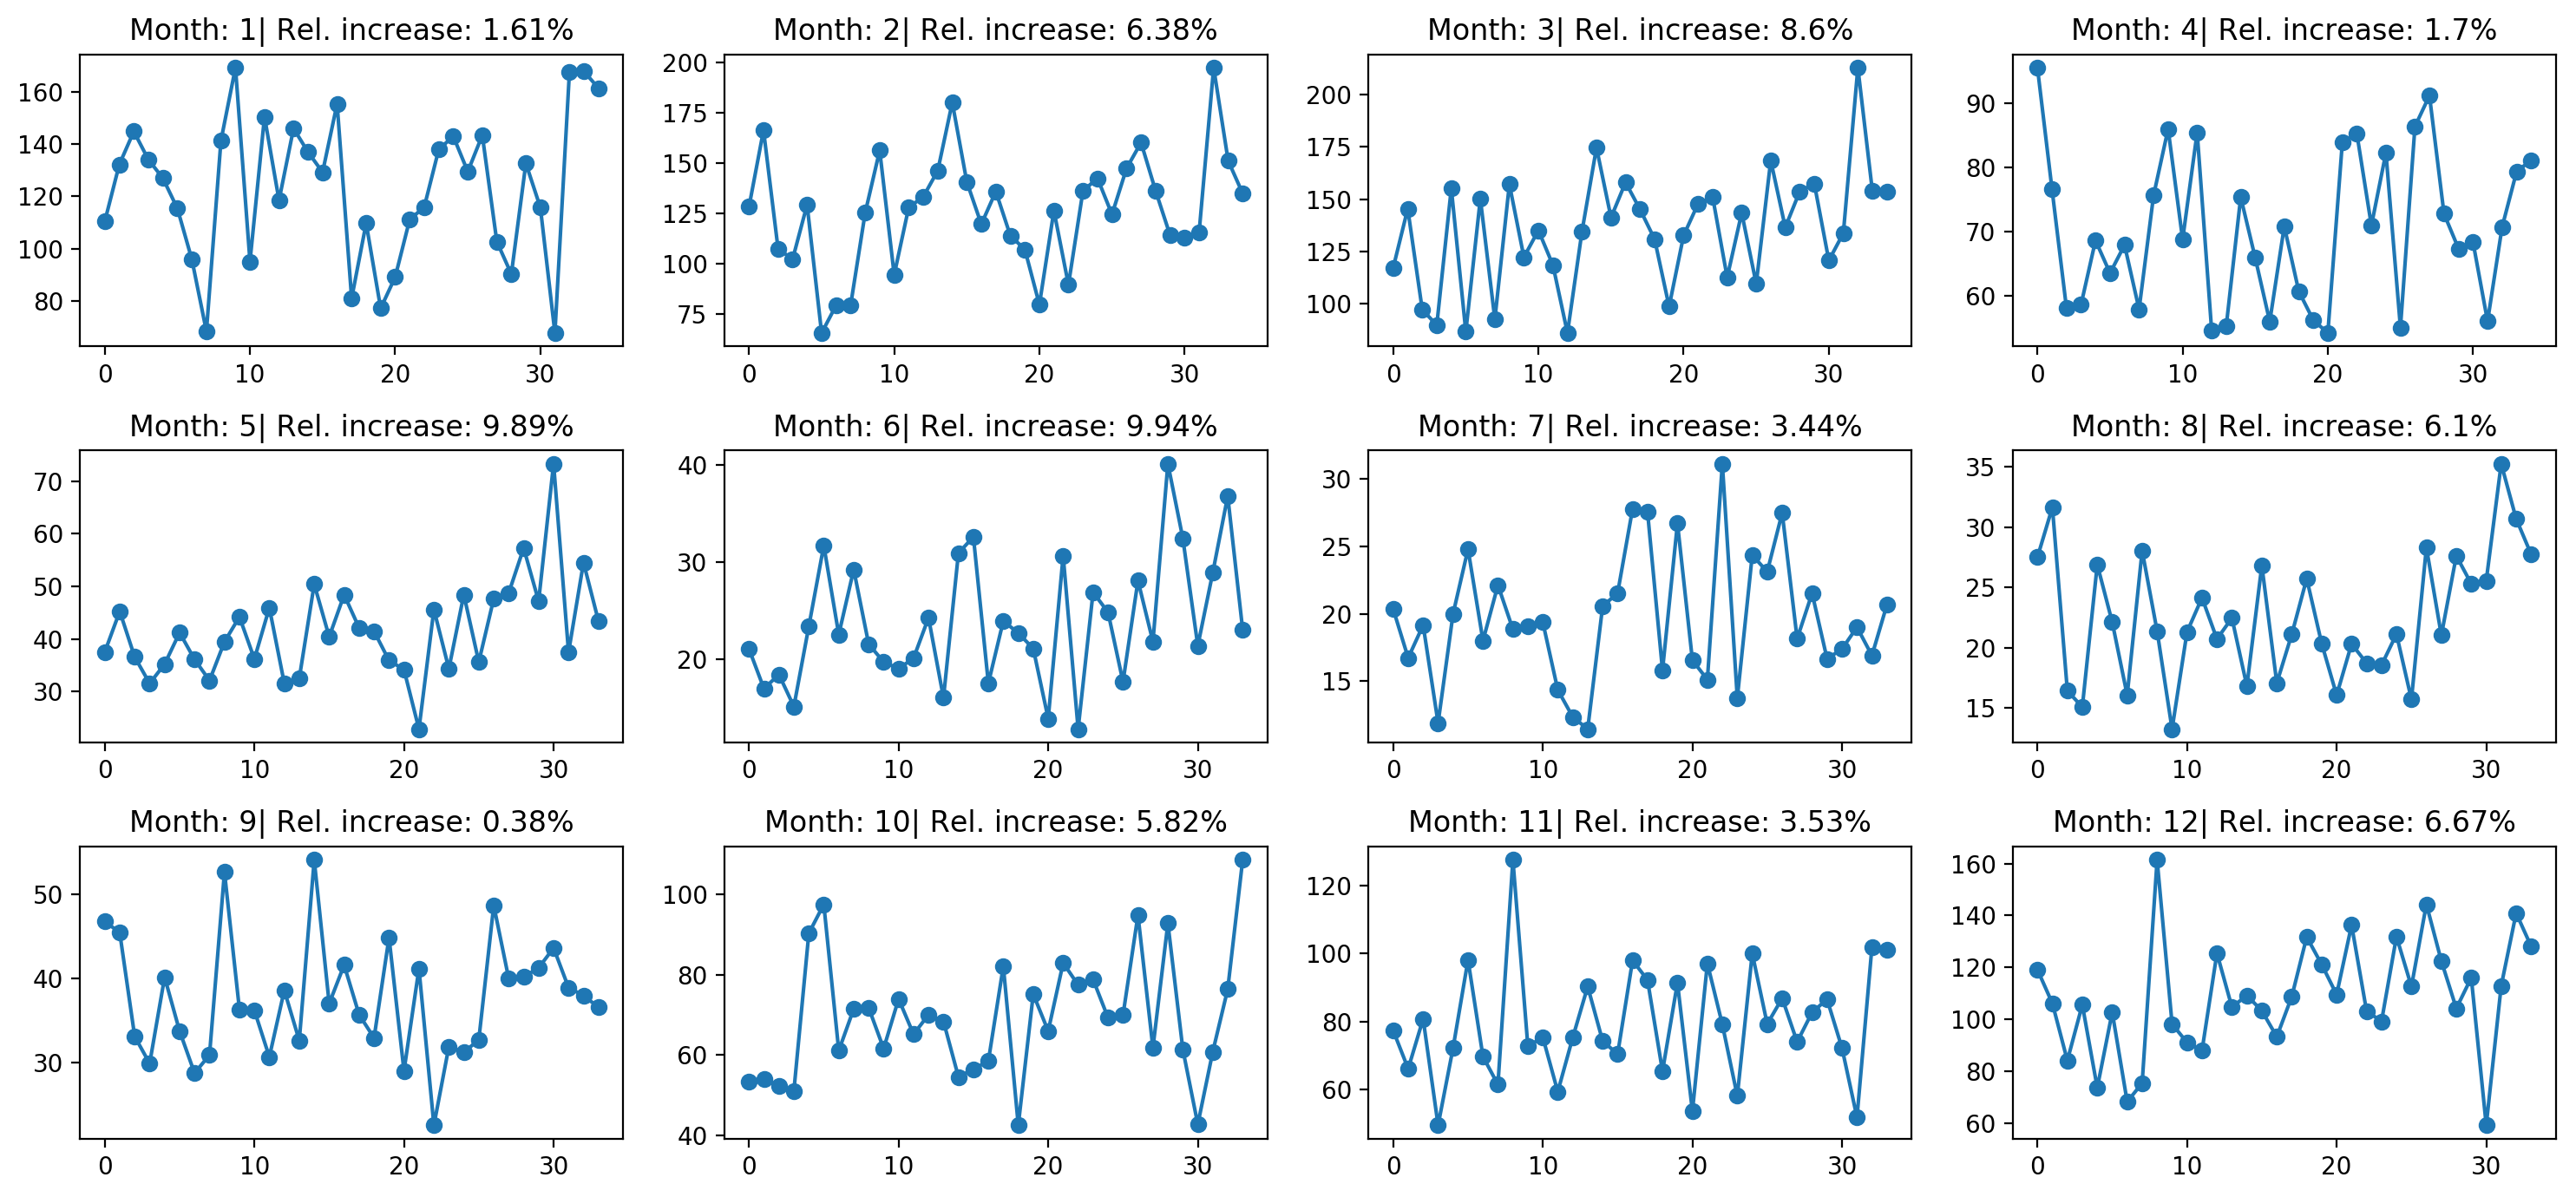

In [8]:
f = plt.figure(figsize=(15,7), dpi=200)
for ids, mm in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):

    ax = f.add_subplot(3,4,ids+1)
    sep = da3[da3['time.month']==mm].mean(['latitude', 'longitude'])
    slope, ints = np.polyfit(np.arange(len(sep)), sep, 1)
    plt.plot(sep, '-o')
    plt.title('Month: '+str(mm)+ '| Rel. increase: '+str(np.round(slope*10/np.mean(sep.values)*100,2))+'%')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_mean_1985-2019.jpg')

In [9]:
def file_loop(inputs):
    
    fpath = '/home/ck/DIR/cornkle/data/HUARAZ/'
    
    m = inputs[0]
    da = inputs[1]
    
    if type(m)==int:
        m = [m]
    
    sig = False
    method='linregress'

    tirtrend, tirmean = calc_trend(da, m, method=method, sig=sig, wilks=False)
    tirm_mean = tirmean.mean('year')
    
    trend = tirtrend['slope']
    pval = tirtrend['pval']


    trend_da = xr.DataArray(trend, coords=[da['latitude'], da['longitude']], dims=['latitude','longitude'])
    trend_da.name = 'ndvi_trend'
    
    sig_da = xr.DataArray(pval, coords=[da['latitude'], da['longitude']], dims=['latitude','longitude'])
    sig_da.name = 'pval'
    
    mean_da = xr.DataArray(tirm_mean, coords=[da['latitude'], da['longitude']], dims=['latitude','longitude'])
    mean_da.name ='ndvi_mean'
    
    monthly = da.groupby('time.month').count('time')
    
    ds = xr.Dataset()
    ds['ndvi_trend'] = trend_da
    ds['ndvi_mean'] = mean_da
    ds['pval'] = sig_da
    ds['valid'] = monthly[monthly['month']==m[0]]

    
    ds.to_netcdf(fpath + 'CHIRPStrend_long_'+method+'_'+str(m).zfill(2)+'.nc')

In [33]:
m = [9,10,11,12,1,2,3,4,5,6,7,8]
for mm in m:

    file_loop((mm, da3))

Entering trend calc
Entering trend calc
Entering trend calc


KeyboardInterrupt: 

In [10]:
fname = '/home/ck/DIR/cornkle/data/HUARAZ/'


m=[9,10,11,12,1,2,3,4,5,6,7,8]

inputs = []
for mm in m:
    inputs.append((mm,da3))

import multiprocessing


pool = multiprocessing.Pool(processes=4)

res = pool.map(file_loop, inputs)

pool.close()

Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc


In [3]:
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)

In [4]:
flist = []
for mm in [1,2,3,4,5,6,7,8,9,10,11,12]:
    flist.append('/home/ck/DIR/cornkle/data/HUARAZ/CHIRPStrend_long_linregress_['+str(mm)+'].nc')

mfd = xr.open_mfdataset(flist, concat_dim='id', combine='nested')

In [5]:
ndvi_trend = mfd['ndvi_trend'].load()


In [6]:
ndvi_trend.latitude

<xarray.DataArray 'latitude' (latitude: 127)>
array([-14.975002, -14.924999, -14.875   , -14.825001, -14.775002, -14.725002,
       -14.674999, -14.625   , -14.575001, -14.525002, -14.475002, -14.424999,
       -14.375   , -14.325001, -14.275002, -14.225002, -14.174999, -14.125   ,
       -14.075001, -14.025002, -13.975002, -13.924999, -13.875   , -13.825001,
       -13.775002, -13.725002, -13.674999, -13.625   , -13.575001, -13.525002,
       -13.475002, -13.424999, -13.375   , -13.325001, -13.275002, -13.225002,
       -13.174999, -13.125   , -13.075001, -13.025002, -12.975002, -12.924999,
       -12.875   , -12.825001, -12.775002, -12.725002, -12.674999, -12.625   ,
       -12.575001, -12.525002, -12.475002, -12.424999, -12.375   , -12.325001,
       -12.275002, -12.225002, -12.174999, -12.125   , -12.075001, -12.025002,
       -11.975002, -11.924999, -11.875   , -11.825001, -11.775002, -11.725002,
       -11.674999, -11.625   , -11.575001, -11.525002, -11.475002, -11.424999,
       -11.375   , -11.325001, -11.275002, -11.225002, -11.174999, -11.125   ,
       -11.075001, -11.025002, -10.975002, -10.924999, -10.875   , -10.825001,
       -10.775002, -10.725002, -10.674999, -10.625   , -10.575001, -10.525002,
       -10.475002, -10.424999, -10.375   , -10.325001, -10.275002, -10.225002,
       -10.174999, -10.125   , -10.075001, -10.025002,  -9.975002,  -9.924999,
        -9.875   ,  -9.825001,  -9.775002,  -9.725002,  -9.674999,  -9.625   ,
        -9.575001,  -9.525002,  -9.475002,  -9.424999,  -9.375   ,  -9.325001,
        -9.275002,  -9.225002,  -9.174999,  -9.125   ,  -9.075001,  -9.025002,
        -8.975002,  -8.924999,  -8.875   ,  -8.825001,  -8.775002,  -8.725002,
        -8.674999], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -14.975002 -14.924999 ... -8.725002 -8.674999
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude
    axis:           Y

In [7]:
ndvi_mean = mfd['ndvi_mean'].load()

In [8]:
mfd

<xarray.Dataset>
Dimensions:     (id: 12, latitude: 127, longitude: 100, month: 12)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude    (latitude) float32 -14.975002 -14.924999 ... -8.725002 -8.674999
  * longitude   (longitude) float32 -79.975006 -79.925 ... -75.075005 -75.025
Dimensions without coordinates: id
Data variables:
    ndvi_trend  (id, latitude, longitude) float64 nan nan nan ... -6.056 -6.378
    ndvi_mean   (id, latitude, longitude) float32 nan nan ... 237.56499
    pval        (id, latitude, longitude) float64 dask.array<chunksize=(1, 127, 100), meta=np.ndarray>
    valid       (id, month, latitude, longitude) float64 dask.array<chunksize=(1, 12, 127, 100), meta=np.ndarray>

In [9]:
means = ndvi_mean.squeeze()

<Figure size 26x18 with 0 Axes>

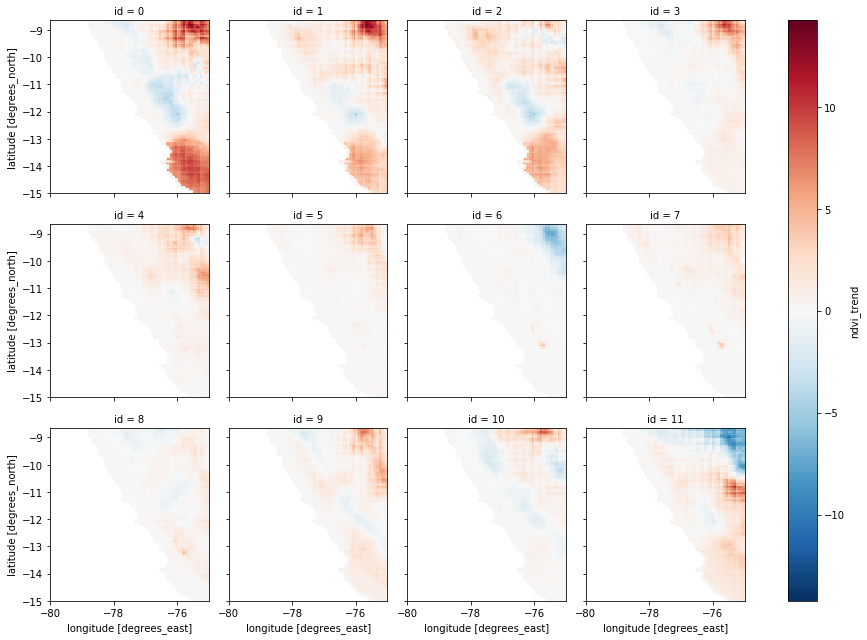

In [10]:
f = plt.figure(figsize=(13,9), dpi=2)
ndvi_trend.plot(x="longitude", y="latitude", col="id", col_wrap=4)

In [11]:
valmask = np.isfinite(means[means['id']==7]).astype(int).squeeze()

In [12]:
np.sum(valmask)

<xarray.DataArray 'ndvi_mean' ()>
array(5852)

In [13]:
pval = mfd['pval'].load()

In [14]:
sig = ndvi_trend.copy()
sig.values[pval.values>0.05] = 0
#sig = sig.where(pval.values<=0.05)

In [15]:
np.sum(ndvi_trend.values[pval.values>0.05])

23381.563162305214

In [16]:
np.sum(sig.values[pval.values>0.05])

0.0

In [110]:
#ndvi_trend = ndvi_trend.sel(latitude=slice(-10.2,-8.63), longitude=slice(-78, -77))

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

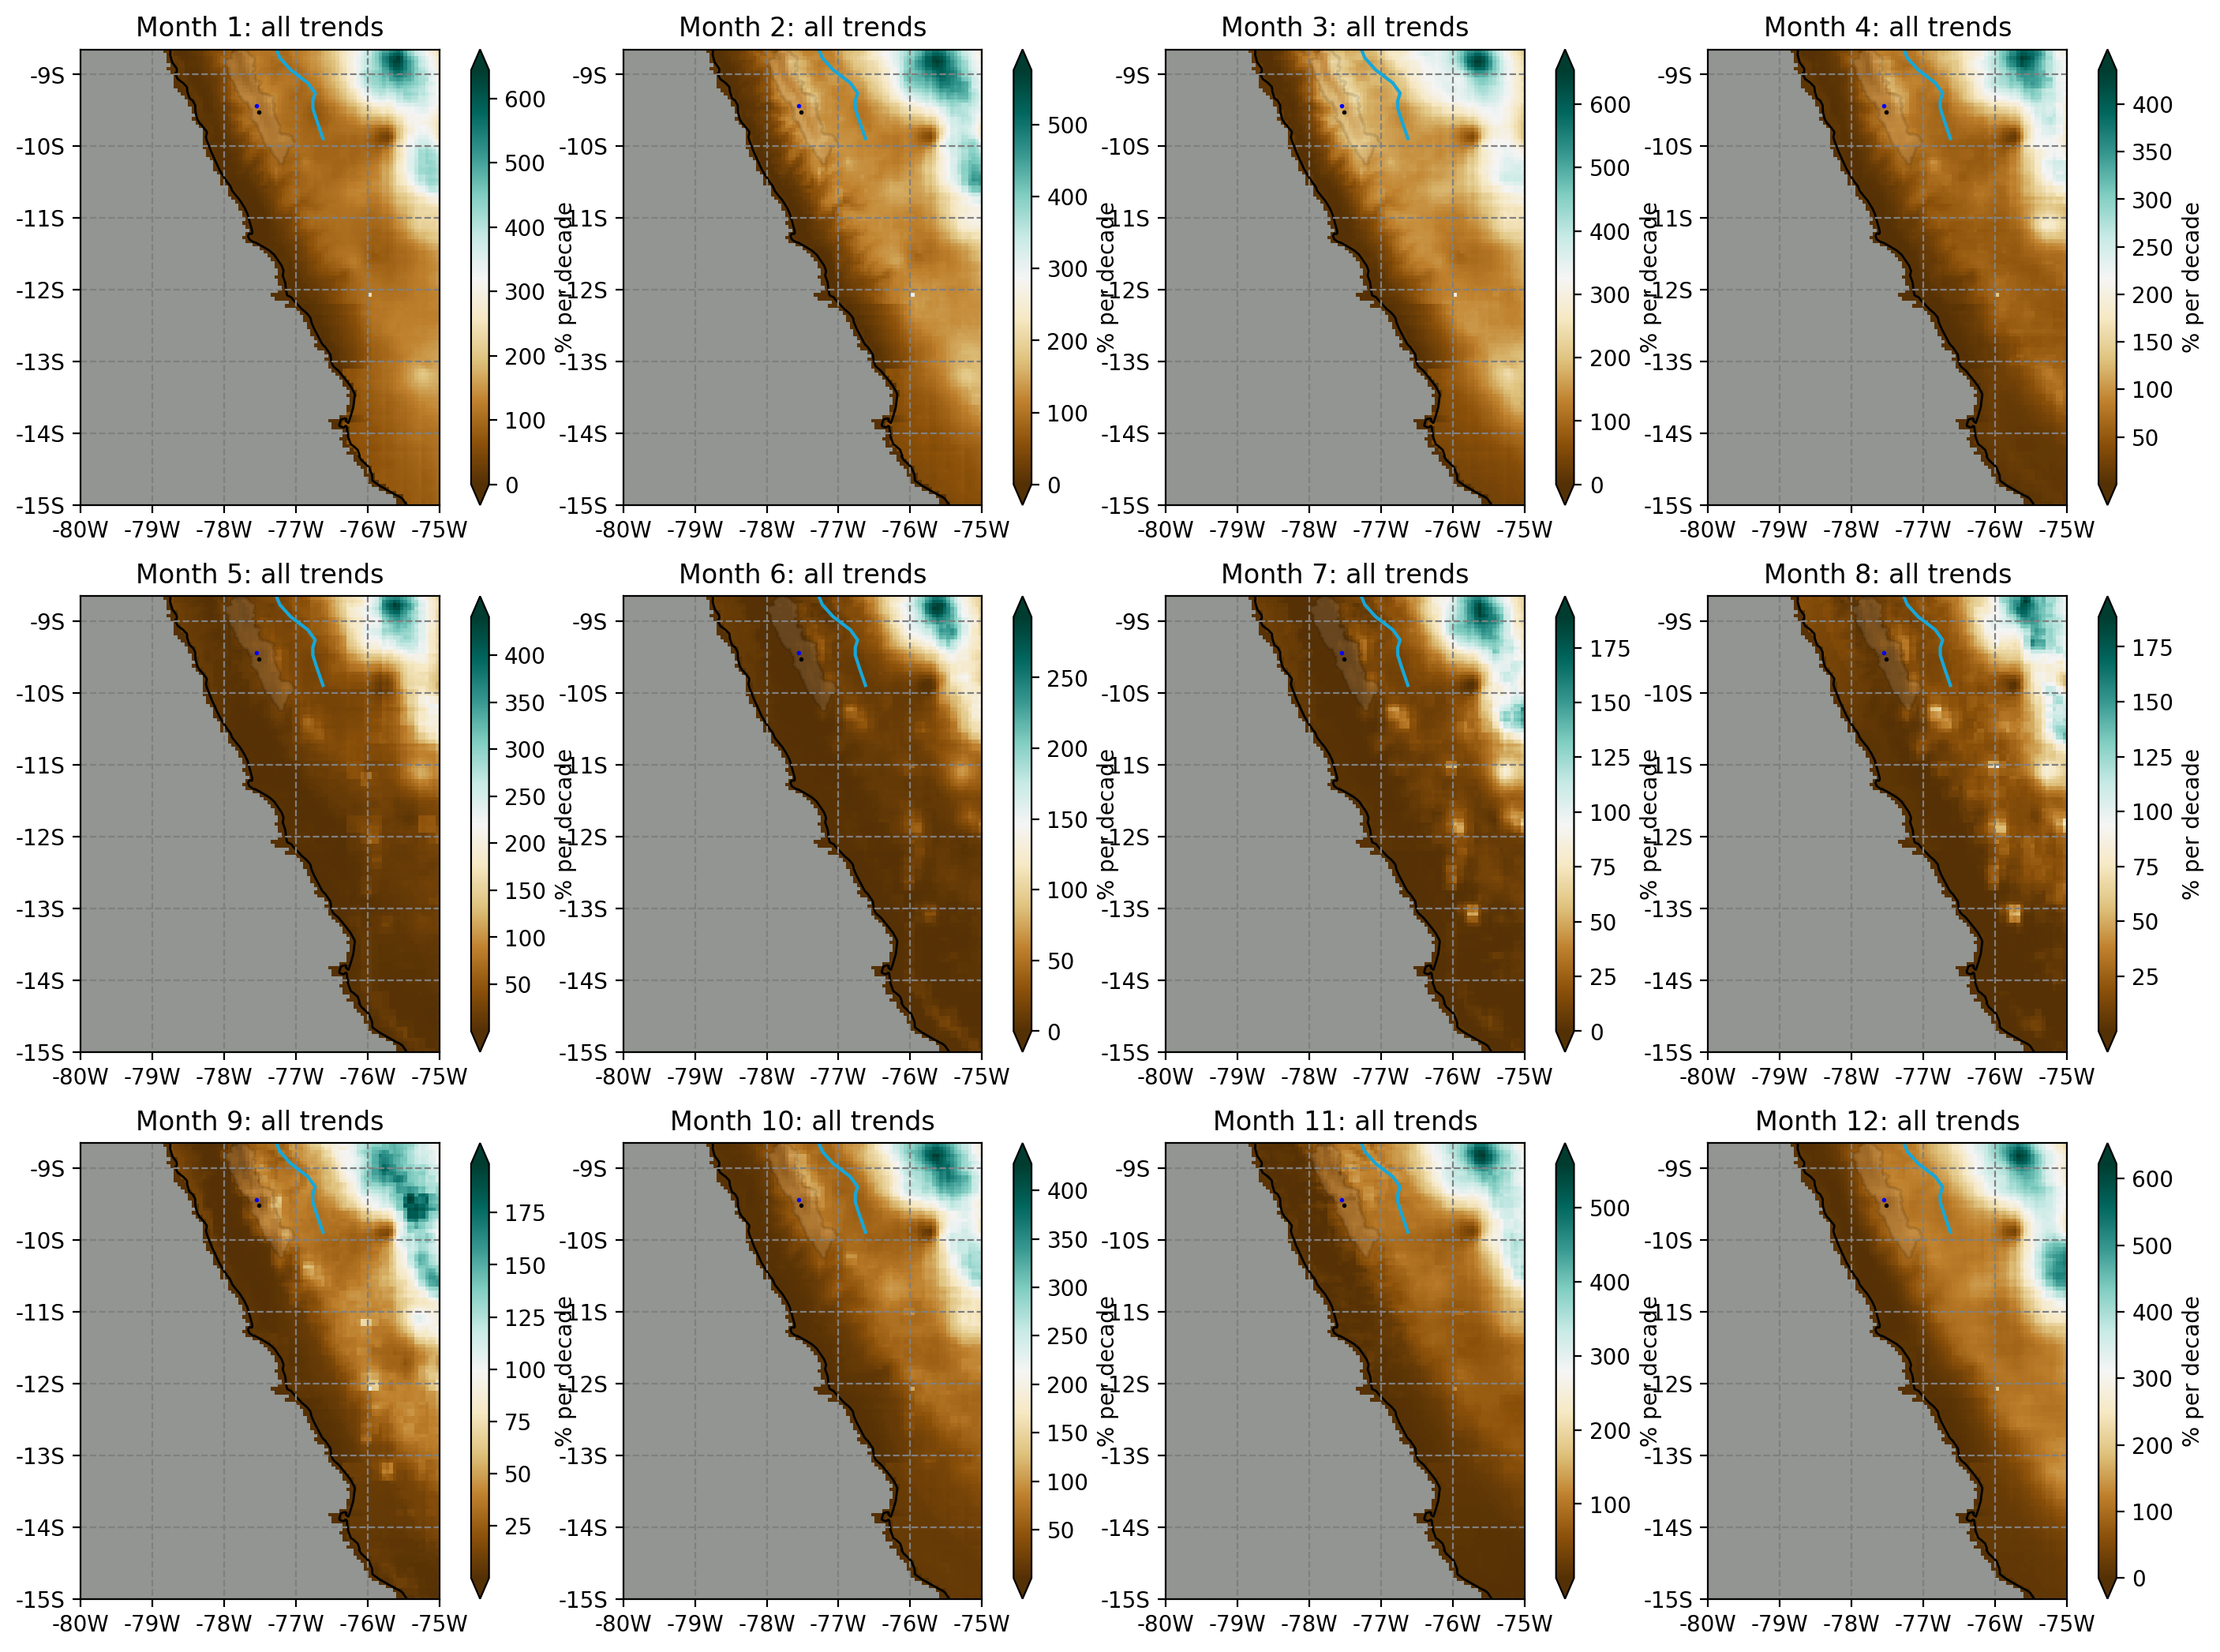

In [17]:
m=1
smap = ndvi_trend.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(cmap='BrBG', extend='both') #levels=np.linspace(-20, 20, 8)
smap.set_shapefile(rivers=True)
smap.set_shapefile(lakes=True, facecolor='blue', edgecolor='blue')

x, y = smap.grid.transform(-77.52, -9.52)
xx, yy = smap.grid.transform(-77.55, -9.438)

cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], ndvi_trend):
    
    mmean = ndvi_mean.isel(id=cnt)

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)
    plt.plot(xx, yy, 'bo', markersize=1)


    smap.set_data(mmean) #np.round(pl*10,2)/mmean*100)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='% per decade')
    cnt += 1
    
plt.tight_layout
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_trend_2000-2019_rel.jpg')

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

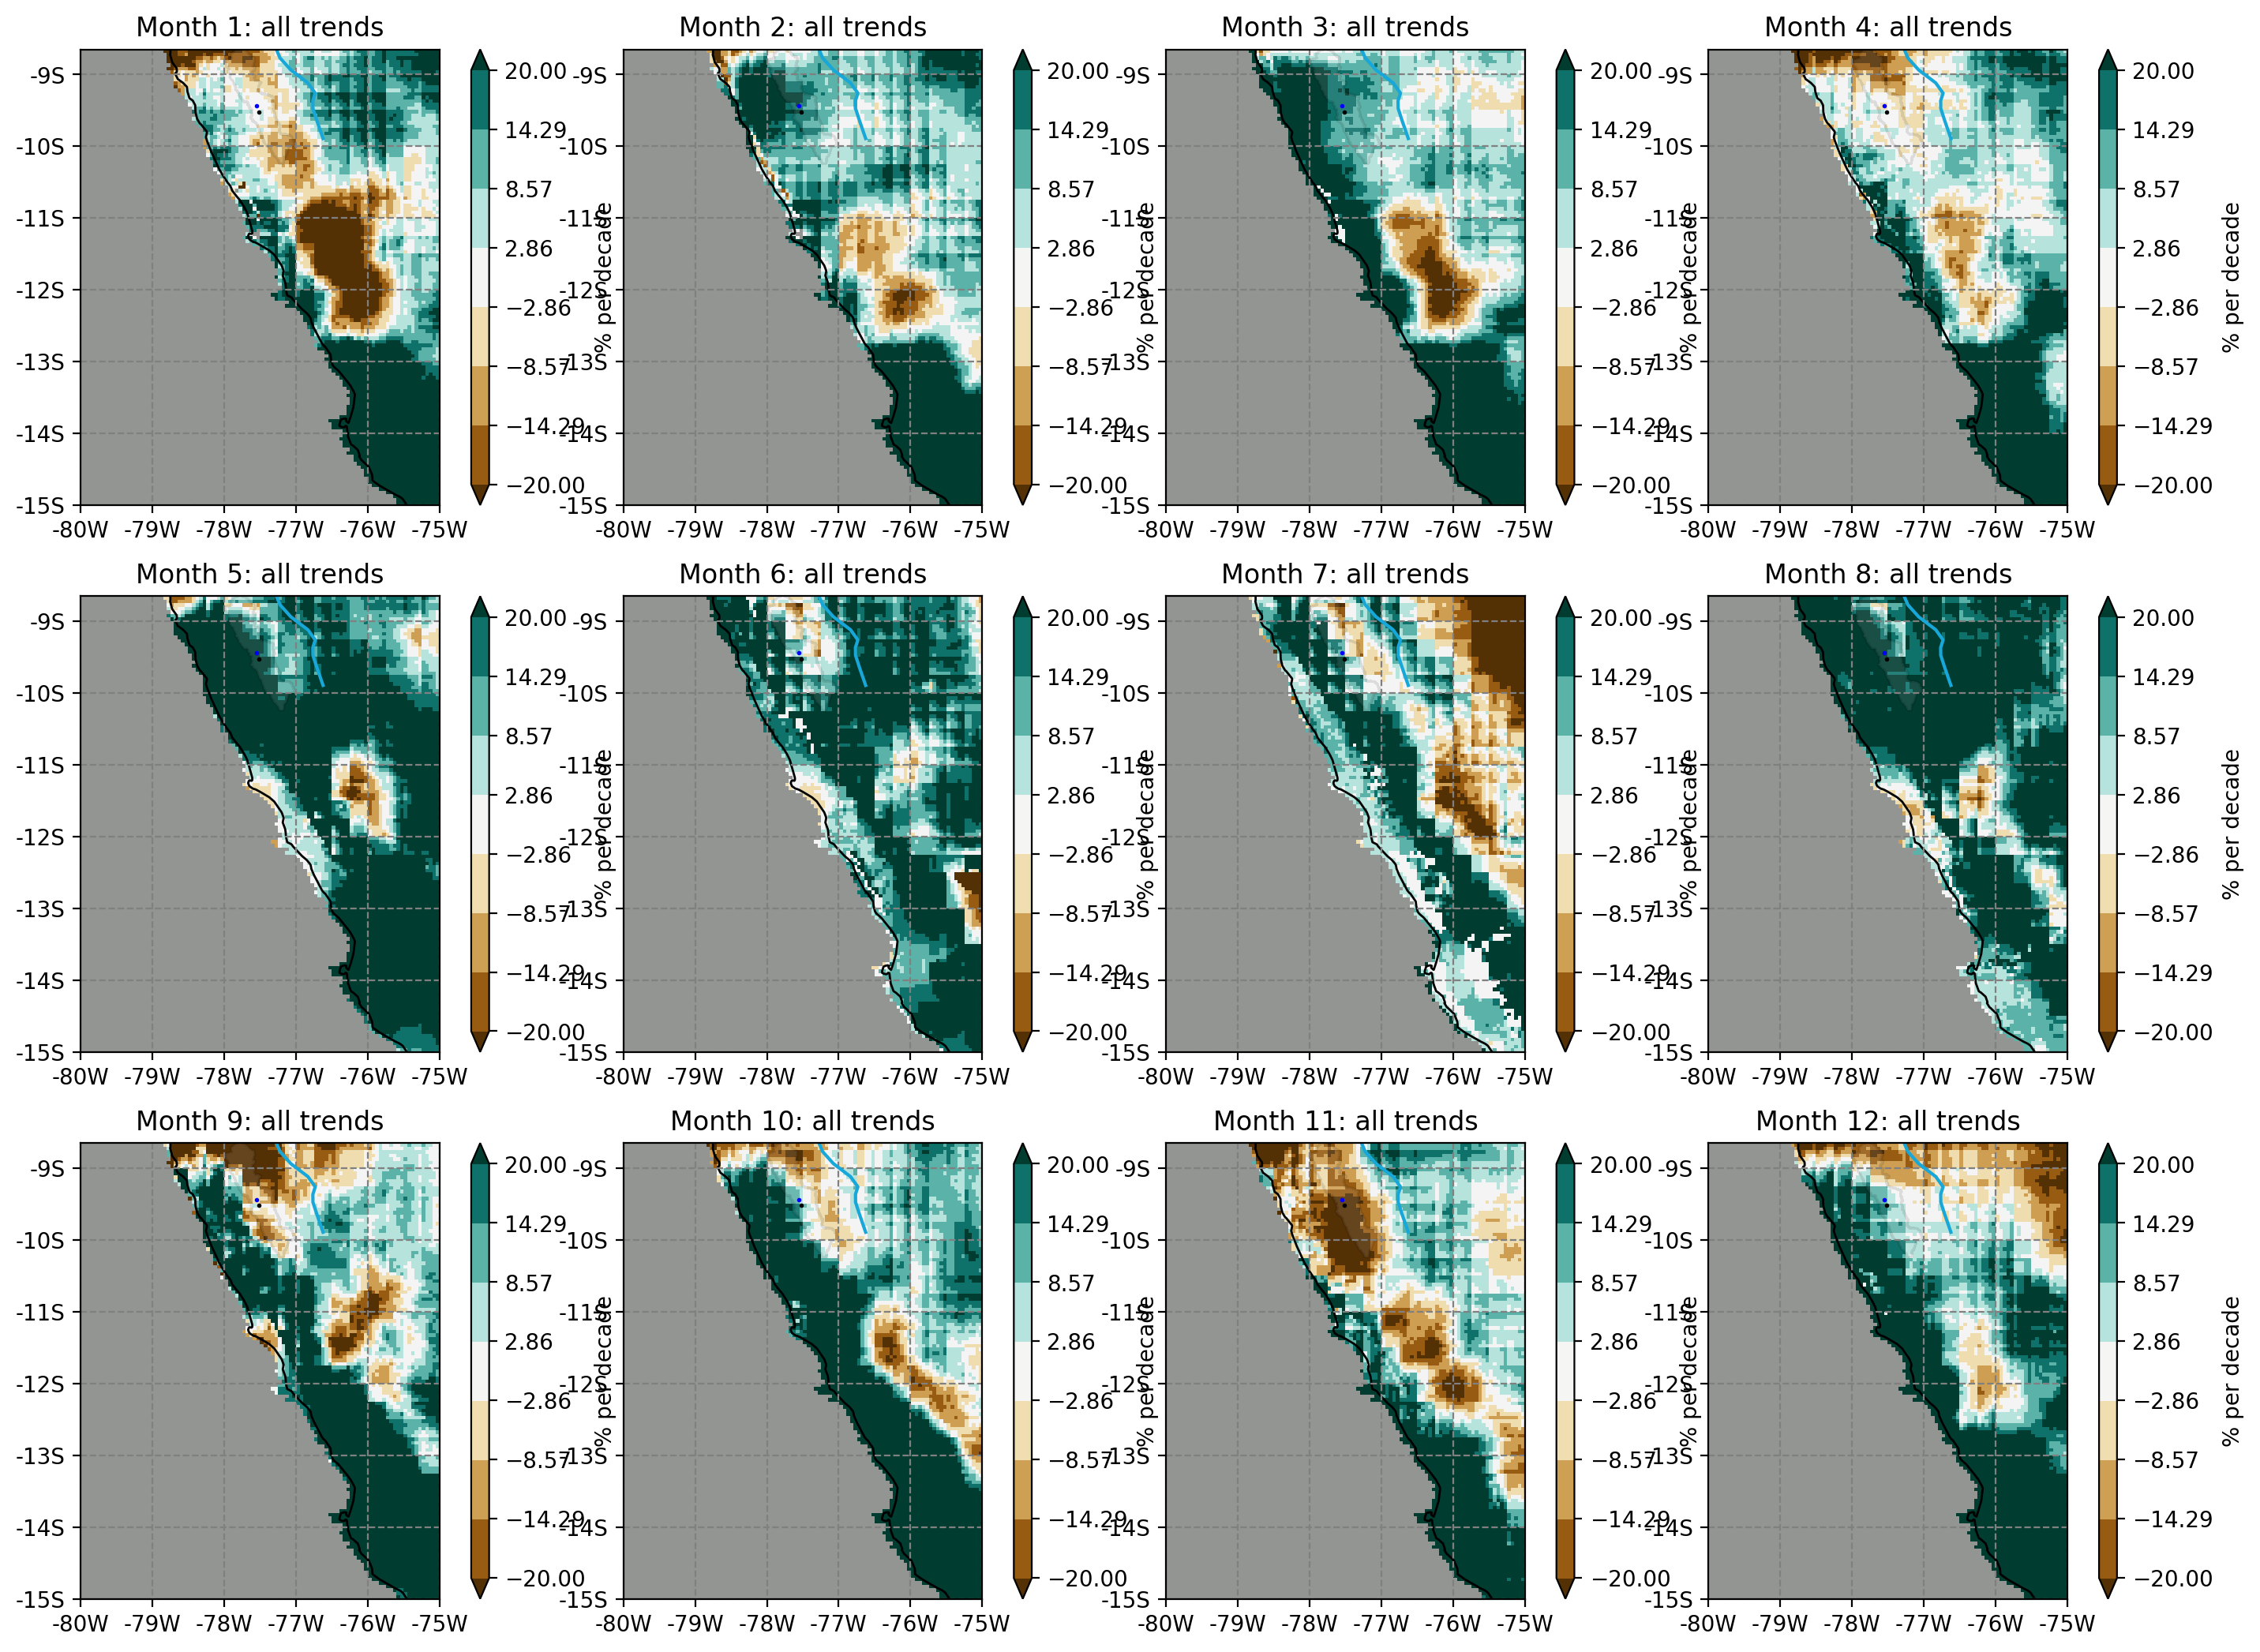

In [18]:
m=1
smap = ndvi_trend.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=np.linspace(-20, 20, 8), cmap='BrBG', extend='both')
smap.set_shapefile(rivers=True)
smap.set_shapefile(lakes=True, facecolor='blue', edgecolor='blue')

x, y = smap.grid.transform(-77.52, -9.52)
xx, yy = smap.grid.transform(-77.55, -9.438)

cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], ndvi_trend):
    
    mmean = ndvi_mean.isel(id=cnt)

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)
    plt.plot(xx, yy, 'bo', markersize=1)


    smap.set_data(np.round(pl*10,2)/mmean*100)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='% per decade')
    cnt += 1
    
plt.tight_layout
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_trend_2000-2019_rel.jpg')

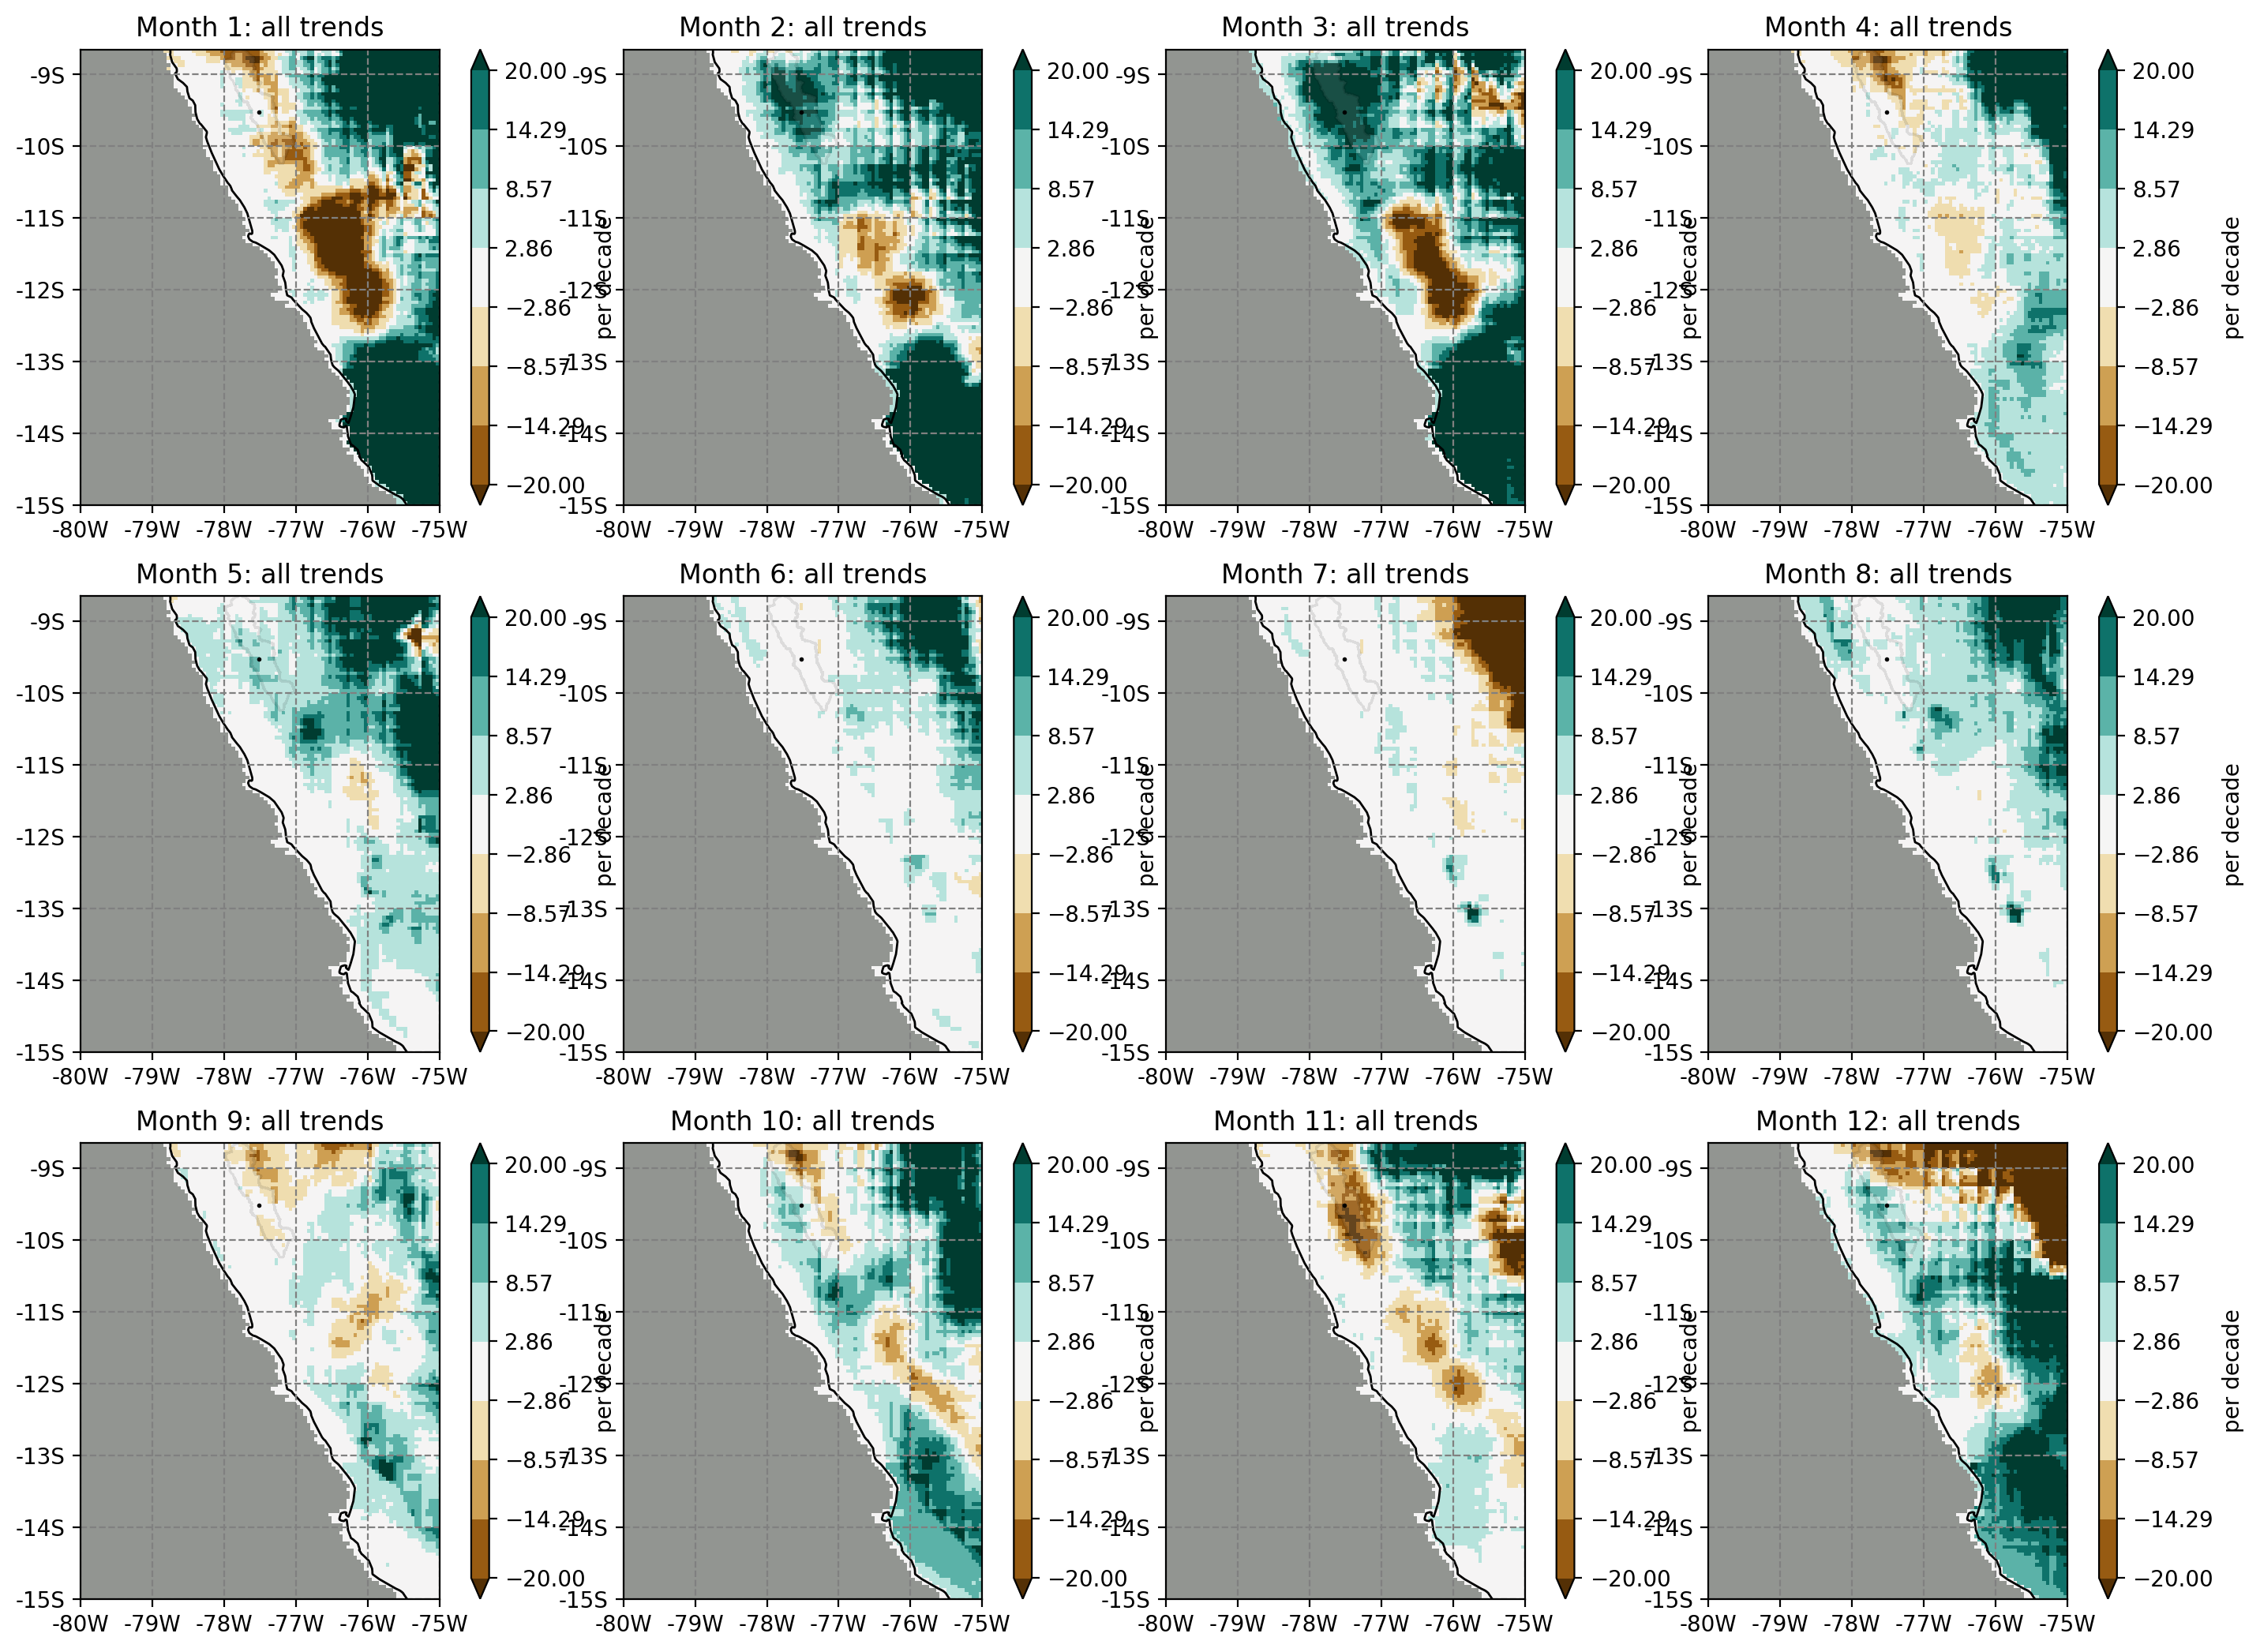

In [19]:
m=1
smap = ndvi_trend.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=np.linspace(-20, 20, 8), cmap='BrBG', extend='both')
cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], ndvi_trend):
    

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)

    smap.set_data(np.round(pl,2)*10)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='per decade')
    cnt += 1
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_trend_2000-2019.jpg')

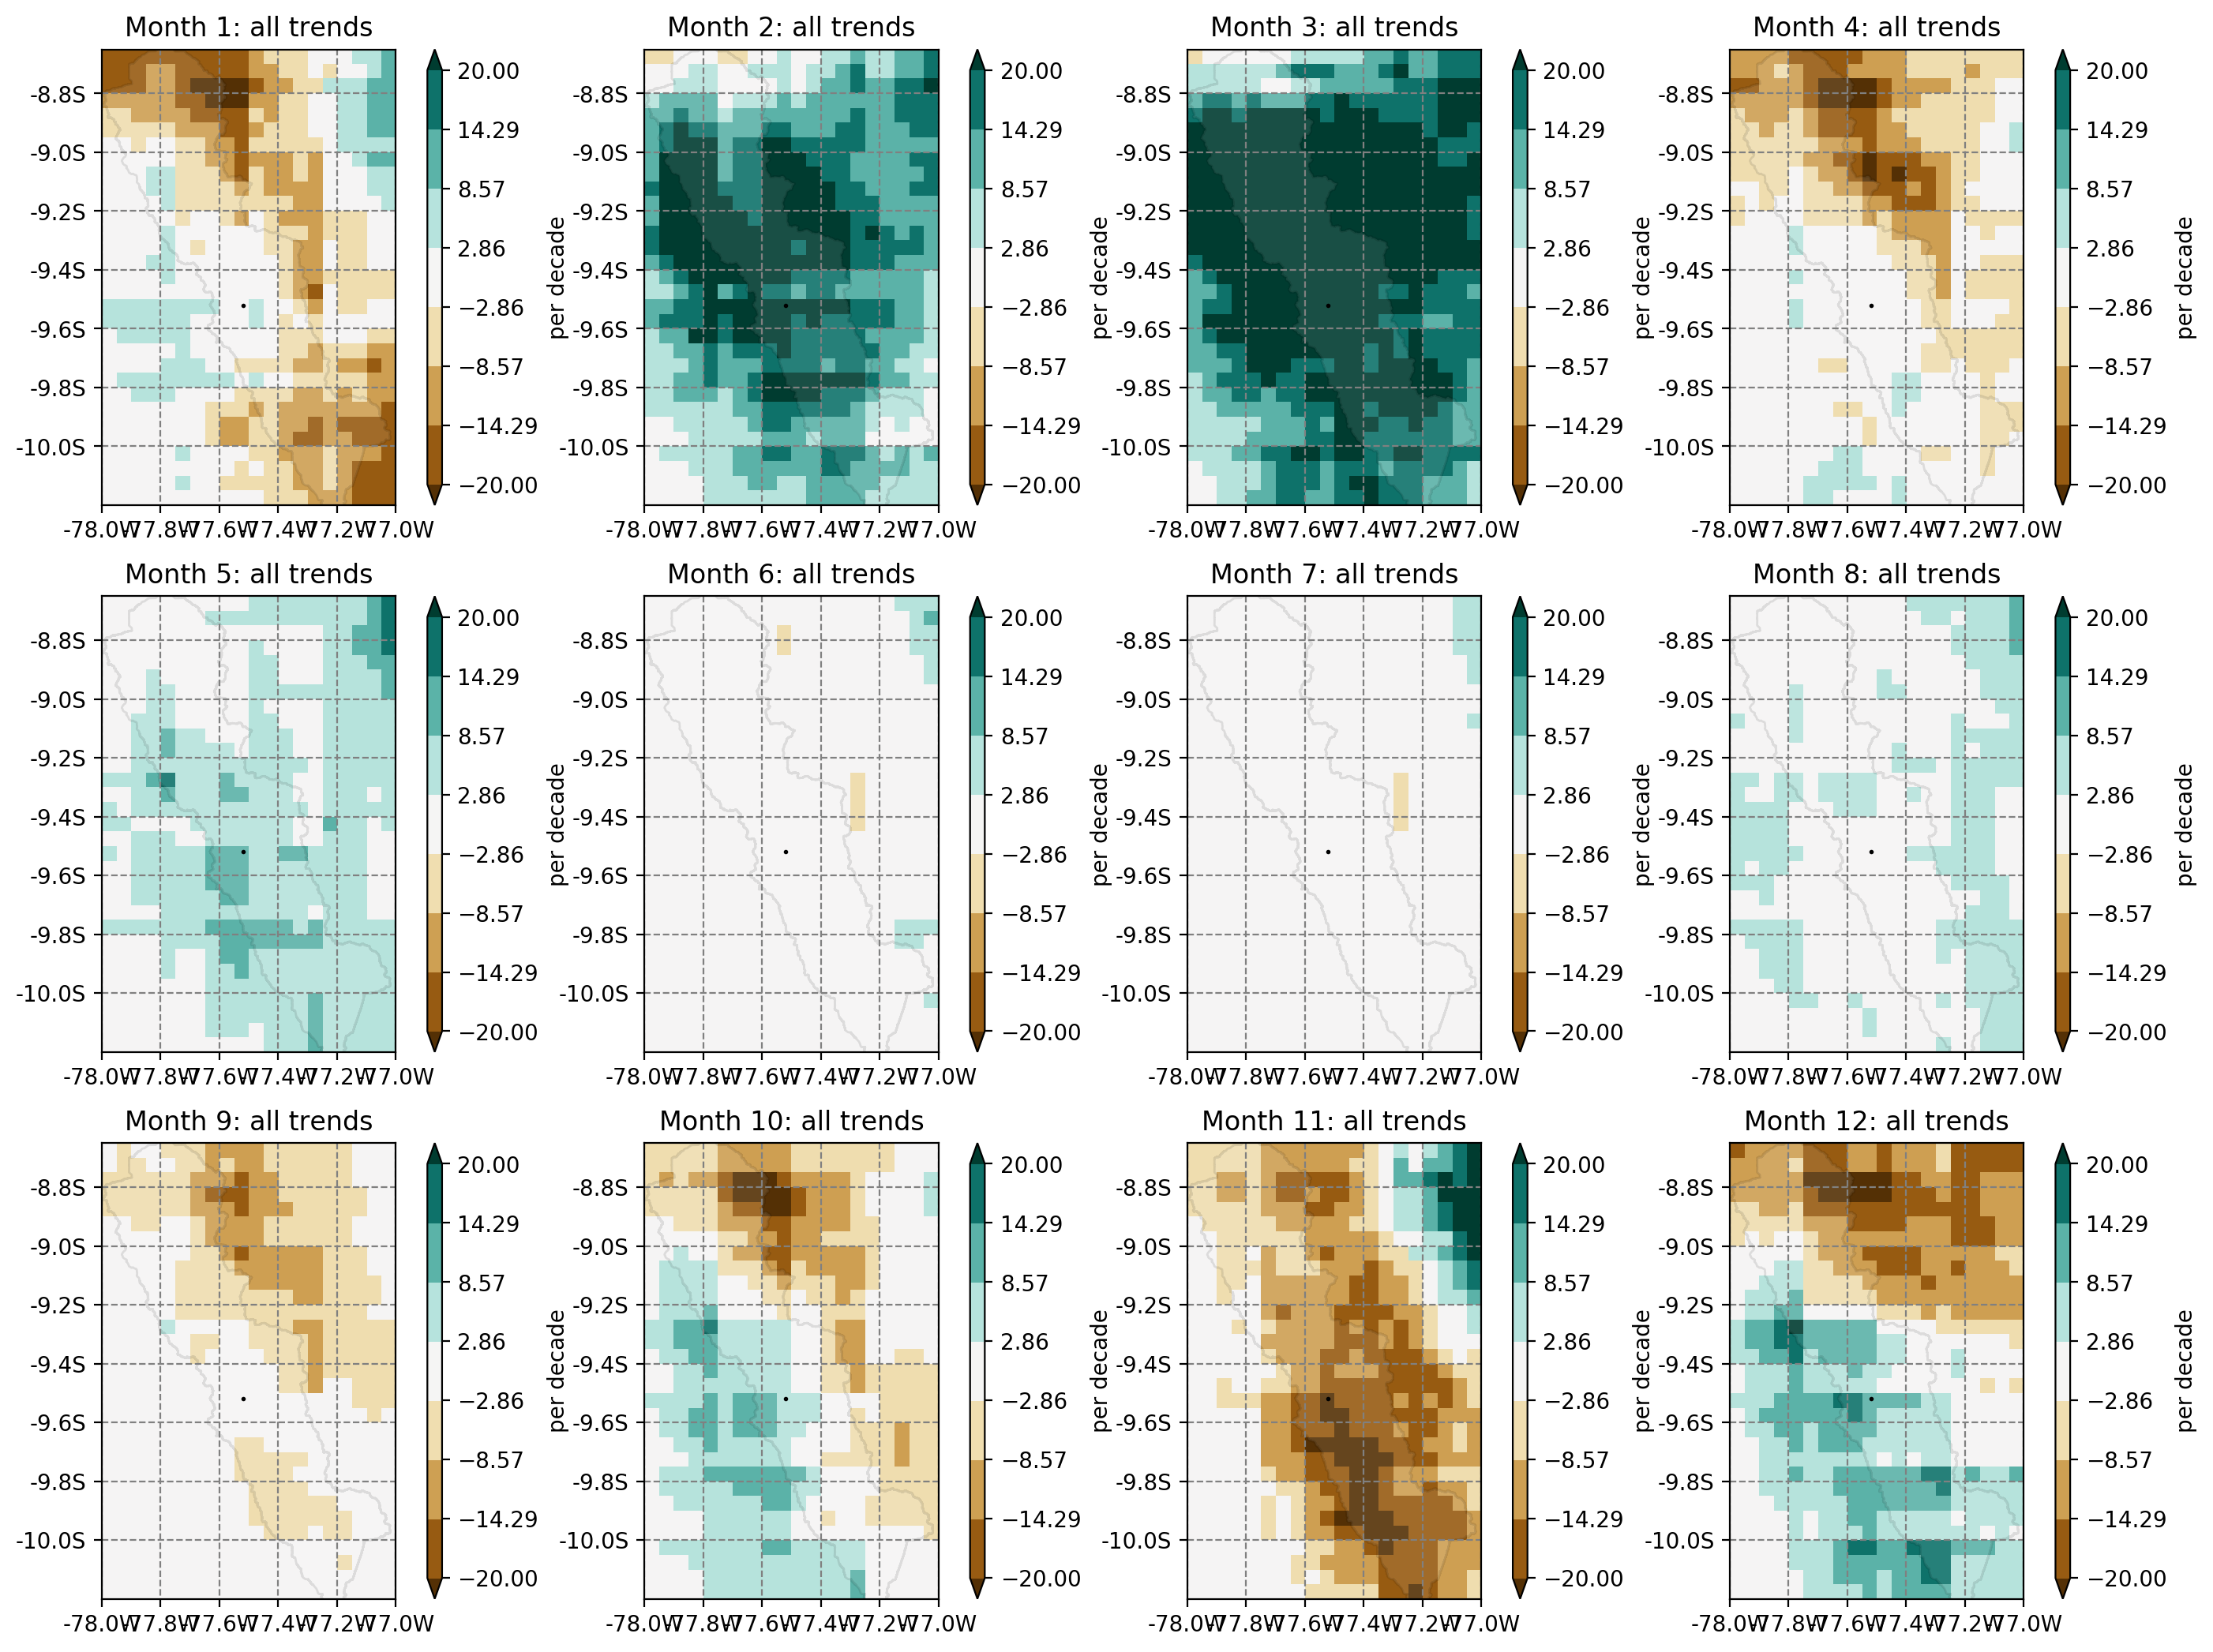

In [112]:
m=1
smap = ndvi_trend.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=np.linspace(-20, 20, 8), cmap='BrBG', extend='both')
cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], ndvi_trend):
    

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)

    smap.set_data(np.round(pl,2)*10)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='per decade')
    cnt += 1
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_trend_2000-2019.jpg')

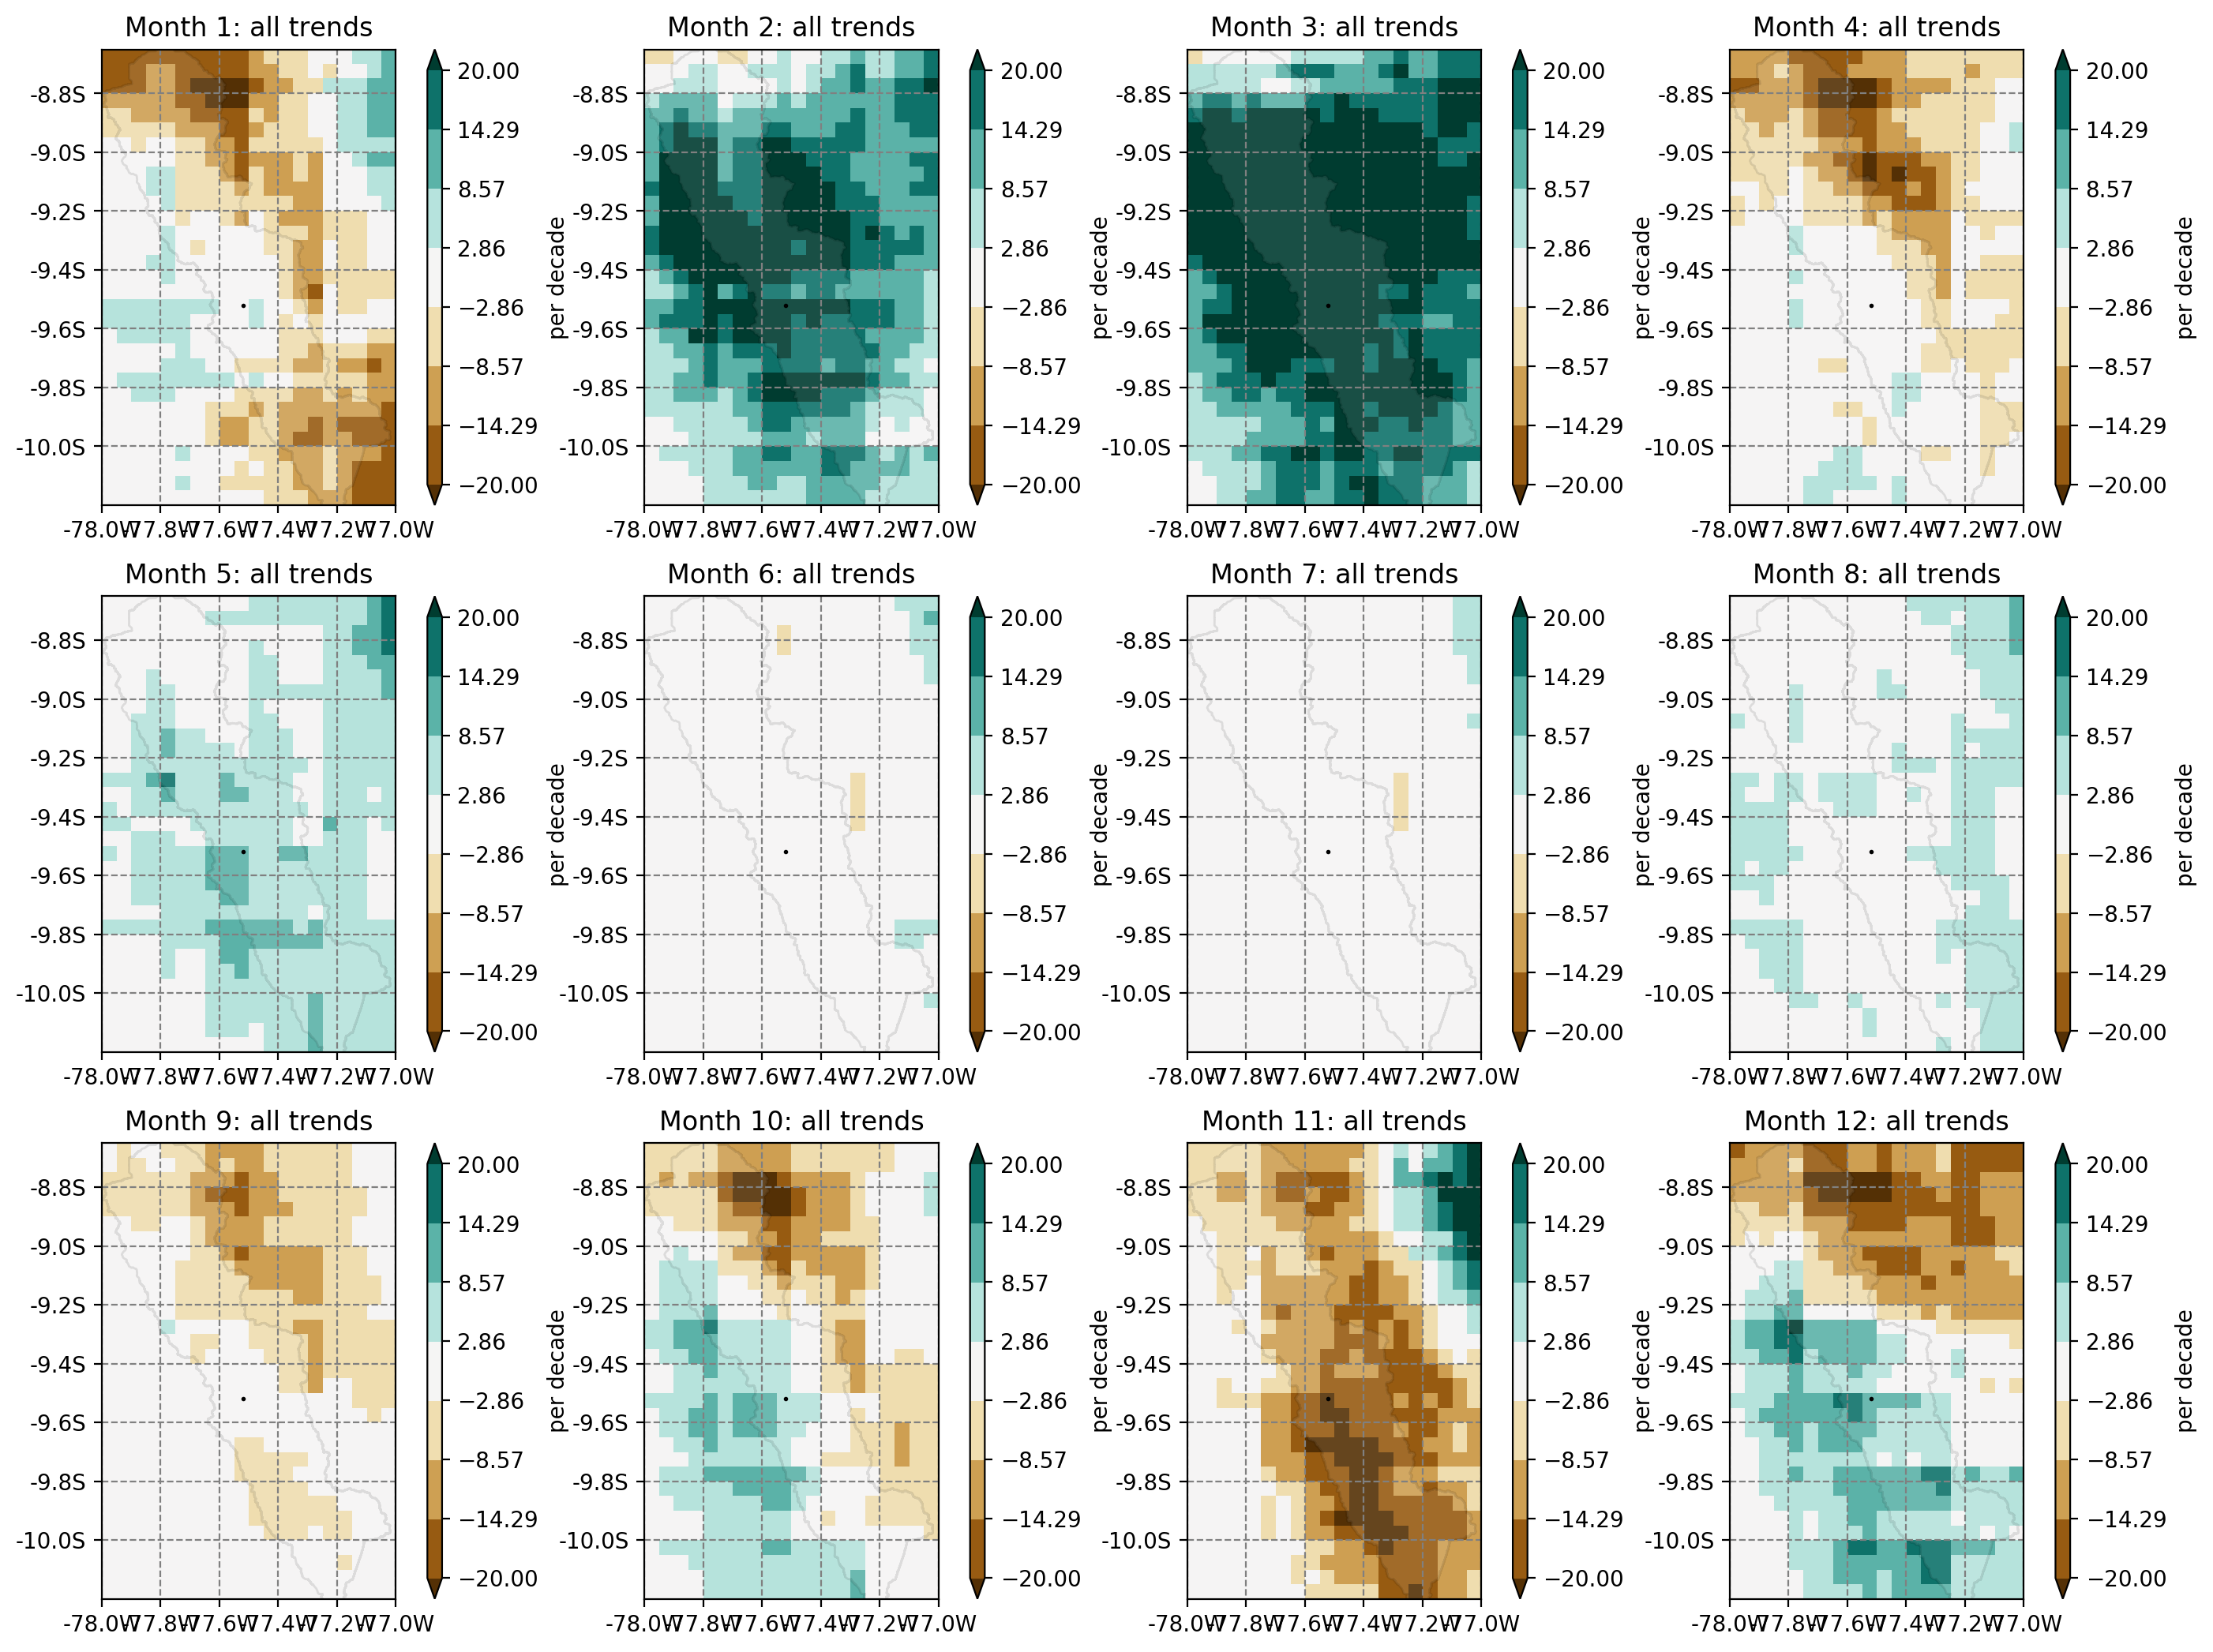

In [26]:
m=1
smap = ndvi_trend.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=np.linspace(-20, 20, 8), cmap='BrBG', extend='both')
cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], ndvi_trend):
    

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)

    smap.set_data(np.round(pl,2)*10)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='per decade')
    cnt += 1
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_trend_2000-2019.jpg')

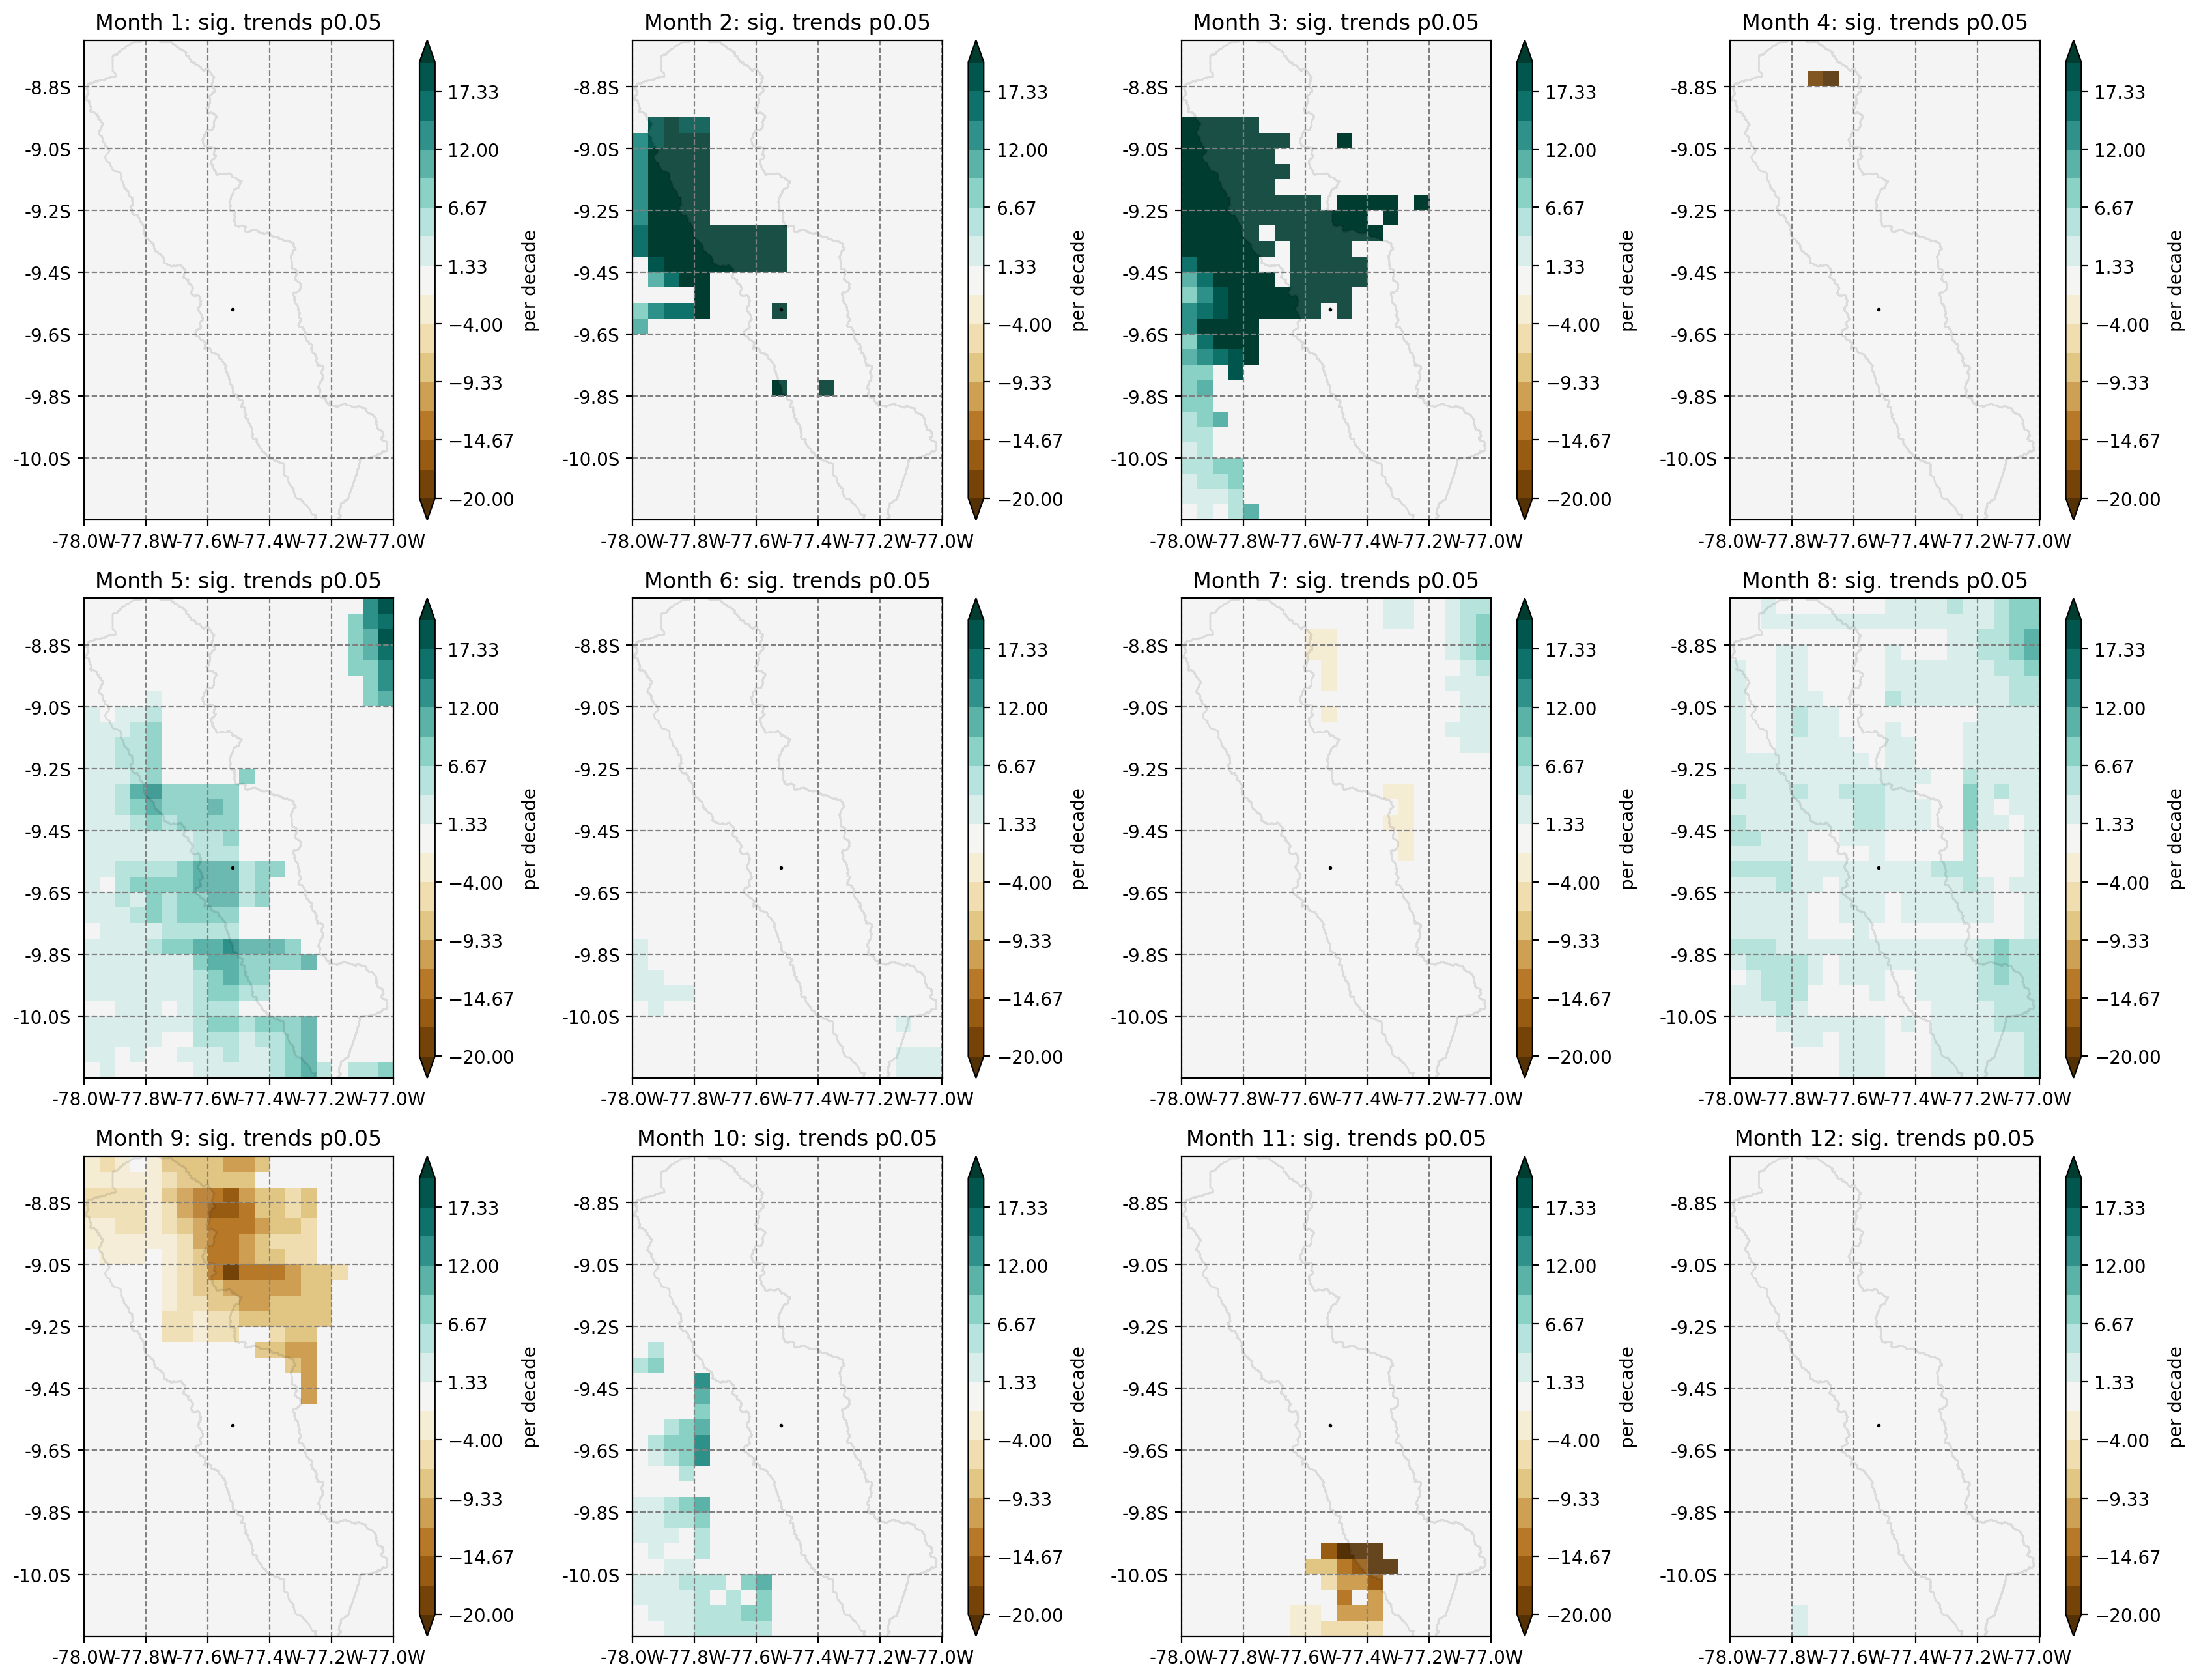

In [29]:
m=1
smap = sig.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=np.linspace(-20, 20, 16), cmap='BrBG', extend='both')
cnt = 1
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], sig):

    ax = f.add_subplot(3,4,cnt)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)

    smap.set_data(np.round(pl,2)*10)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': sig. trends p0.05', cbar_title='per decade')
    cnt += 1
    
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_sigtrend_2000-2019.jpg')

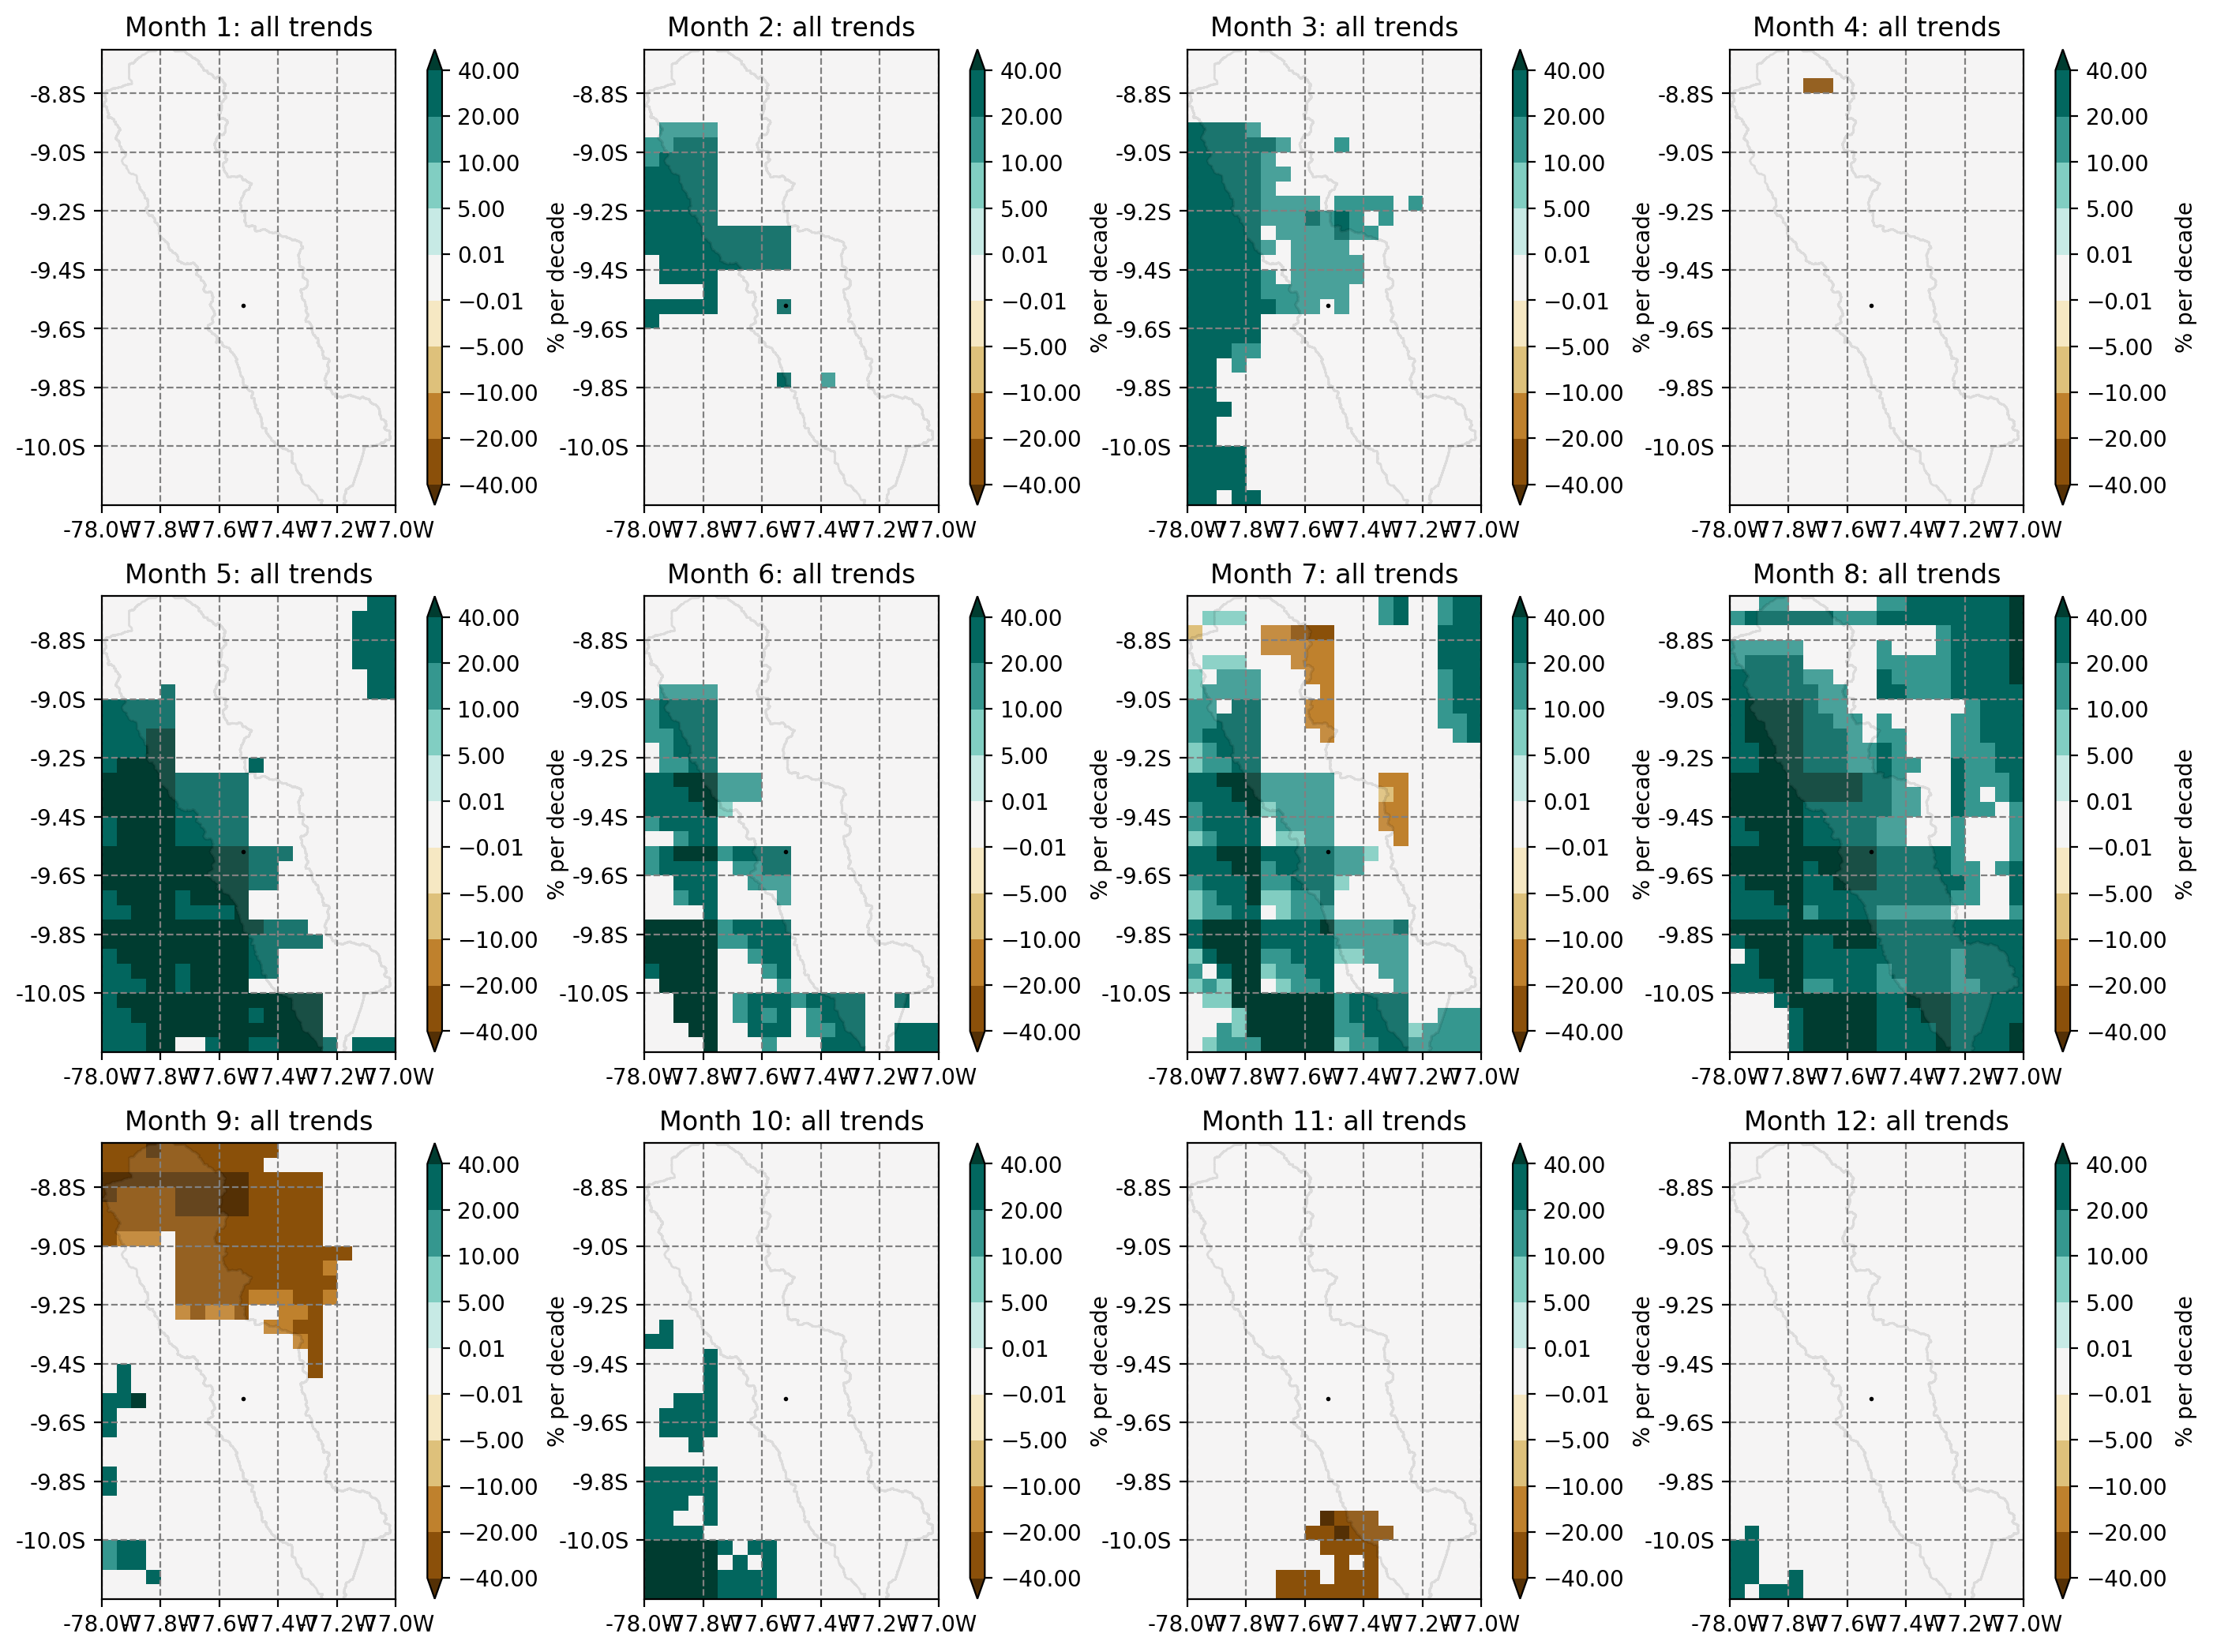

In [28]:
m=1
smap = sig.salem.get_map()
f = plt.figure(figsize=(17,13), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(levels=[-40,-20,-10,-5,-0.01,0.01,5,10,20,40], cmap='BrBG', extend='both')
cnt = 0
for m, pl in zip([1,2,3,4,5,6,7,8,9,10,11,12], sig):
    
    mmean = ndvi_mean.isel(id=cnt)

    ax = f.add_subplot(3,4,cnt+1)
    ax.set_facecolor('xkcd:grey')
    
    plt.plot(x, y, 'ko', markersize=1)

    smap.set_data(np.round(pl*10,2)/mmean*100)
    smap.visualize(ax=ax,addcbar=True, title='Month '+str(m)+ ': all trends', cbar_title='% per decade')
    cnt += 1
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/NDVI_trends/CHIRPS_linregress_sigtrend_2000-2019_rel.jpg')